# 연관분석

## 1. 라이브러리

In [1]:
# 필요한 모듈 import
import matplotlib.pyplot as plt
import pandas as pd
import mpld3

mpld3.enable_notebook()

## 2. 파일 불러오기

In [2]:
data = pd.read_excel('최종 합친 데이터_mecab까지.xlsx')
data = data.dropna(subset=['noun_va'], axis=0).reset_index(drop=True)

In [3]:
data.head()

,Unnamed: 0,name,date,comment,site,Year,Month,comment_lemma,nouns,va,noun_va
0,0,mika,2021-07-30,세컨드카로 아이오닉 구형 전기차를 구매해서 사용하고 있다. 면허증 갱신은 두 번 했...,블로그,2021,7,세컨드/NNP 카로/NNP 아이오닉/NNP 구형/NNG 구매/NNG 사용/NNG 면...,세컨드 카로 아이오닉 구형 구매 사용 면허증 갱신 그동안 운전 남편 초보 장단점 단...,크다 번거롭다 비싸다 좋다 맑다 좋다 좋다 작다 좋다,세컨드 카로 아이오닉 구형 구매 사용 면허증 갱신 그동안 운전 남편 초보 장단점 단...
1,1,holic,2021-07-28,전기차 충전소 사용기 홀릭이랑헤윰이랑 제주도 여행 오늘은 지난 제주도 여행에서 전기...,블로그,2021,7,충전소/NNP 사용기/NNP 홀릭/NNP 윰/NNP 제주도/NNP 여행/NNG 오늘...,충전소 사용기 홀릭 제주도 여행 오늘 제주도 여행 충전소 방문 충전 이야기 제주도 ...,가볍다 좋다 짧다 이쁘다 괜찮다 다르다 좋다 많다 다르다 다르다 덥다 크다 어렵다 ...,충전소 사용기 홀릭 제주도 여행 오늘 제주도 여행 충전소 방문 충전 이야기 가볍다 ...
2,2,달의궁전,2019-09-16,오늘은 제가 타고 다니는 아이오닉 일렉트릭 전기차 유지비용 및 구입 후 장착한 옵션...,블로그,2019,9,오늘/NNG 아이오닉/NNP 일렉트릭/NNP 유지/NNG 비용/NNG 구입/NNG ...,오늘 아이오닉 일렉트릭 유지 비용 구입 장착 옵션 세대 전기 요즘 출시 코나 니로 ...,짧다 좋다 좋다 늦다 괜찮다 높다,오늘 아이오닉 일렉트릭 유지 비용 구입 장착 옵션 세대 전기 요즘 출시 코나 니로 ...
3,3,피터,2021-06-13,전기차 충전 파워 큐브 이동형 사용기 작년 11월 테슬라 모델 S를 타고 있다. 약...,블로그,2021,6,충전/NNP 파워/NNP 큐브/NNP 이동형/NNP 사용기/NNP 작년/NNG 테슬...,충전 파워 큐브 이동형 사용기 작년 테슬라 모델 KM 운행 이사 출퇴근 거리 편도 ...,짧다 빠르다 크다 나쁘다 좋다 좋다 좋다 귀찮다 높다 빠르다 좋다 크다 짧다 크다 ...,충전 파워 큐브 이동형 사용기 작년 테슬라 모델 KM 운행 이사 출퇴근 거리 편도 ...
4,4,제주홍당무,2019-10-12,전기자동차 중고 구입 후 한 달 사용기 보조금 문제 등을 알아보고 전기차 충전과 주...,블로그,2019,10,중고/NNG 구입/NNG 사용기/NNP 보조금/NNP 문제/NNG 충전/NNP 주행...,중고 구입 사용기 보조금 문제 충전 주행성능 단상 결론 순간 구입 고민 고민 조금 ...,많다 좋다 짧다 넓다 넓다 좋다 많다 좋다 짧다 짧다 작다 짧다 쉽다 세차다 어렵다...,중고 구입 사용기 보조금 문제 충전 주행성능 단상 결론 순간 구입 고민 많다 고민 ...


## 3. 연관분석 후 네트워크 시각화

In [4]:
from apyori import apriori
from collections import Counter
import decorator
import networkx as nx
import matplotlib

# 연관분석부터 네트워크 시각화까지 한 번에 하는 함수 정의
def get_network(data, start_day, end_day, top_n=500, n_iter=1000, size_div=500, font_size=4, width=3, most_option=0, va=True):

    """
    1. 데이터 관련 파라미터
    start_day   : 분석에 사용할 데이터 시작일
    end_day     : 분석에 사용할 데이터 종료일
    va          : True일 경우 형용사도 포함
    top_n       : 연관규칙을 지지도 기준으로 정렬하였을 때, 상위 top_n개의 연관규칙만 edge로 추가함 (0일 경우 모두 추가)
    most_option : 단어별로 빈도수 기준으로 정렬하였을 때, 상위 most_option개의 단어만 node로 추가함 
                  (0일 경우 연관규칙에서 상위 top_n개에 등장하는 단어만 추가함)
    
    
    2. 시각화 관련 파라미터
    n_iter      : 레이아웃(position) 설정에서 반복횟수 (nx.spring_layout의 매개변수)
    font_size   : 레이블(단어)의 폰트 크기
    width       : edge의 너비
    size_div    : node의 사이즈 = 빈도수/size_div
    """
    
    # 형용사 포함 유무 적용
    if va:
        col = 'noun_va'
    else:
        col = 'nouns'
        
    # 설정 날짜에 해당하는 데이터만 선택 (특정 컬럼만 리스트로 저장)
    data_selected = data[(data.date >= start_day) & (data.date <= end_day)]
    data_list = data_selected[col].tolist()

    # 트랜잭션 생성 (한 행이 하나의 트랜잭션이 되며, 항목은 명사 또는 명사와 형용사)
    transactions = []
    for comment in data_list:
        transactions.append(set(word.strip() for word in comment.split(' ') if word.strip() != ''))
        
    # 연관분석 및 데이터프레임화
    results = list(apriori(transactions, min_support=0.01, min_confidence=0.1, min_lift=1.0, max_length = 2))
    columns = ['source', 'target', 'support', 'confidence', 'lift']

    df = []
    for result in results:
        if len(result.items) == 2: # 연관규칙의 길이가 2인 것만 추출 (단어와 단어 사이의 관계를 보기 위해서)
            items = [x for x in result.items]
            for r in result[2]:
                if (len(items[0]) > 0) and (len(items[1]) > 0):
                    row = [items[0], items[1], round(result.support, 5), round(r[2], 5), round(r[3], 5)]
            df.append(row)
    network_df = pd.DataFrame(df, columns=columns)
    
    # 각 단어의 빈도수 계산
    noun_list = []
    for text in data_selected[col]:
        noun_list += [w for w in text.split(' ')]

    counter = Counter(noun_list)
    node_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
    node_df.columns = ['node', 'nodesize']
    
    
    # 그래프 생성
    plt.figure(figsize=(10,10))
    G=nx.Graph()
    
    # top_n == 0일 경우 모든 연관규칙을 불러오기 위하여 top_n을 연관규칙 데이터프레임의 길이로 설정
    if top_n == 0:
        top_n = len(network_df)

    selected_df = network_df.nlargest(top_n, 'support')
    # 시각화에서 node와 edge를 추가할 때, 지지도가 낮은 것부터 추가하여
    # 지지도가 높은 항목의 edge가 위로 올라올 수 있도록 함
    selected_df = selected_df.iloc[::-1].reset_index() 
    # support값을 0~1사이로 스케일링하여 추후 edge의 weight로 씀
    norm_support = [float(i)/max(selected_df['support']) for i in selected_df['support']]
    
    # edge의 색을 저장하는 리스트
    colors = []
    
    # most_option에 따라 그래프에 node와 edge를 추가함
    # nodesize는 빈도수에 비례
    if most_option: # 빈도수 기준 상위 most_option개의 단어만 node로 추가
        node_df = node_df.nlargest(most_option, 'nodesize')
        
        # node 추가
        for index, row in node_df.iterrows():
            G.add_node(row['node'], nodesize=row['nodesize'])

        # edge 추가
        for index, row in selected_df.iterrows():
            # 연관규칙들 중에서 source와 target이 모두 빈도수 기준 most_option개의 단어에 해당할 때에만 edge추가
            if (row['source'] in node_df.node.tolist()) and (row['target'] in node_df.node.tolist()):
                G.add_edge(row['source'], row['target'], weight=norm_support[index])
                colors.append(norm_support[index]) # 두 단어의 지지도를 기반으로 색을 설정할 수 있도록 리스트에 저장

    else:
        # 연관규칙에 해당하는 단어는 모두 단어의 빈도수에 상관없이 node로 추가함
        for index, row in selected_df.iterrows():
            # 해당 node가 이미 존재한다면 추가하지 않음
            if row['source'] not in G.nodes:
                G.add_node(row['source'], nodesize=node_df[node_df['node'] == row['source']]['nodesize'].values[0])
            if row['target'] not in G.nodes:    
                G.add_node(row['target'], nodesize=node_df[node_df['node'] == row['target']]['nodesize'].values[0])
            G.add_edge(row['source'], row['target'], weight=norm_support[index])
            colors.append(norm_support[index]) # 두 단어의 지지도를 기반으로 색을 설정할 수 있도록 리스트에 저장


    # 시각화 레이아웃 설정
    pos = nx.spring_layout(G, k=0.8, iterations=n_iter, seed=1)
    # node의 사이즈 설정 (데이터에 따라 빈도수가 많이 다르므로 수동으로 조정) 
    # = 빈도수(nodesize)/size_div
    sizes = [G.nodes[node]['nodesize']/size_div for node in G]
    
    # colormap이 가질 수 있는 수의 범위로 colors 리스트의 값들을 정규화
    norm = matplotlib.colors.Normalize(vmin=min(colors), vmax=max(colors))
    cmap = matplotlib.cm.Greens
    m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    # node, edge, label 추가
    nx.draw_networkx_nodes(G, pos=pos, node_size=sizes, node_color=sizes,
                           alpha=0.5, cmap=plt.cm.Greens)
    nx.draw_networkx_edges(G, pos=pos, node_size=sizes, edge_color=m.to_rgba(colors), 
                           width = width, alpha=0.7, edge_cmap=plt.cm.Greens)
    nx.draw_networkx_labels(G, pos=pos, font_family="Malgun Gothic", font_size=font_size)

    ax = plt.gca()
    plt.show()

    return network_df

## 3-1. 전체 연도 데이터 

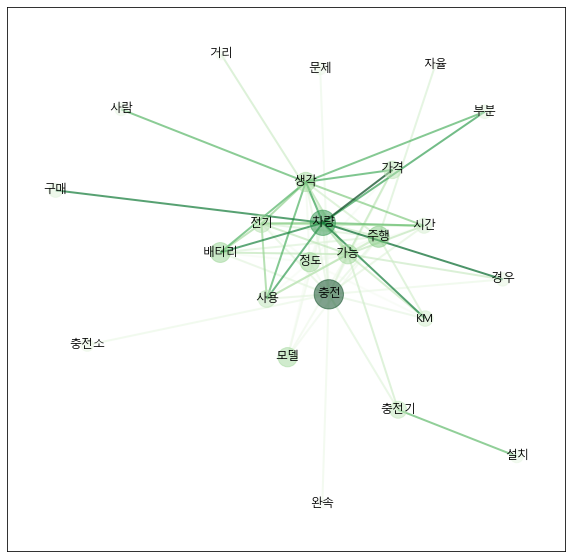

In [5]:
net_total_new = get_network(data, '2016-01-01', '2021-07-31', top_n=70, n_iter=50, size_div=100, font_size=12, width=2, most_option=0, va=False)

### 풀어서 확인 및 파라미터 세팅

In [6]:
data_selected = data[(data.date >= '2016-01-01') & (data.date <= '2021-07-31')]

data_list = data_selected['noun_va'].tolist()

# 트랜잭션 생성
transactions = []
for comment in data_list:
    transactions.append(set(word.strip() for word in comment.split(' ') if word.strip() != ''))

# 연관분석 및 데이터프레임화
results = list(apriori(transactions, min_support=0.01, min_confidence=0.1, min_lift=1.0, max_length = 2))
columns = ['source', 'target', 'support', 'confidence', 'lift']

df = []
for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        for r in result[2]:
            if (len(items[0]) > 0) and (len(items[1]) > 0):
                row = [items[0], items[1], round(result.support, 3), round(r[2], 3), round(r[3], 3)]
        df.append(row)
network_df = pd.DataFrame(df, columns=columns)

In [7]:
# 각 단어의 빈도수 계산
noun_list = []
for text in data_selected['noun_va']:
    noun_list += [w for w in text.split(' ')]

counter = Counter(noun_list)
node_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
node_df.columns = ['node', 'nodesize']

In [8]:
G=nx.MultiGraph()

selected_df = network_df.sort_values('support', ascending=False).head(500).reset_index()
selected_df = selected_df.iloc[::-1]
norm_support = [float(i)/max(selected_df['support']) for i in selected_df['support']]

for index, row in selected_df.iterrows():
    if row['source'] not in G.nodes:
        G.add_node(row['source'], nodesize=node_df[node_df['node'] == row['source']]['nodesize'].values[0])
    if row['target'] not in G.nodes:    
        G.add_node(row['target'], nodesize=node_df[node_df['node'] == row['target']]['nodesize'].values[0])
    G.add_edge(row['source'], row['target'], weight=norm_support[index])

In [9]:
pos = nx.spring_layout(G, k=0.7, iterations=2000, seed=1)
sizes = [G.nodes[node]['nodesize']/800 for node in G]

In [10]:
import matplotlib

norm = matplotlib.colors.Normalize(vmin=min(selected_df['support']), vmax=max(selected_df['support']))
cmap = matplotlib.cm.Greens
m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

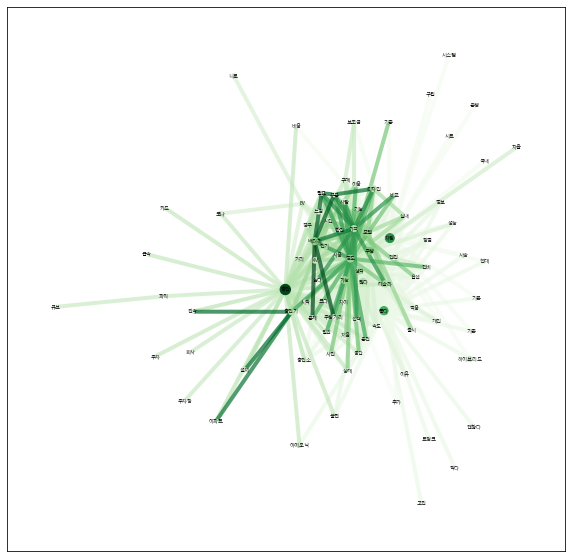

In [11]:
plt.figure(figsize=(10,10))

nx.draw_networkx_nodes(G, pos=pos, node_size=sizes, node_color=sizes,
                       alpha=1, cmap=plt.cm.Greens)
nx.draw_networkx_edges(G, pos=pos, node_size=sizes, edge_color=m.to_rgba(selected_df['support']),
                       width = 4, alpha=0.7, edge_cmap=plt.cm.Greens)
nx.draw_networkx_labels(G, pos=pos, font_family="Malgun Gothic", font_size=5)

ax = plt.gca()
plt.show()

## 3-2. 특정단어를 중심으로: 충전

In [12]:
G=nx.Graph()

selected_df = network_df[(network_df['source'] == '충전') | (network_df['target'] == '충전')].sort_values('support', ascending=False)
selected_df = selected_df.iloc[::-1].reset_index()
norm_support = [float(i)/max(selected_df['support']) for i in selected_df['support']]

for index, row in selected_df.iterrows():
    G.add_node(row['source'], nodesize=node_df[node_df['node'] == row['source']]['nodesize'].values[0])   
    G.add_node(row['target'], nodesize=node_df[node_df['node'] == row['target']]['nodesize'].values[0])
    G.add_edge(row['source'], row['target'], weight=norm_support[index])

In [13]:
pos = nx.spring_layout(G, k=0.7, iterations=1000, seed=1)
sizes = [G.nodes[node]['nodesize']/800 for node in G]

In [14]:
import matplotlib

norm = matplotlib.colors.Normalize(vmin=min(selected_df['support']), vmax=max(selected_df['support']))
cmap = matplotlib.cm.Greens
m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

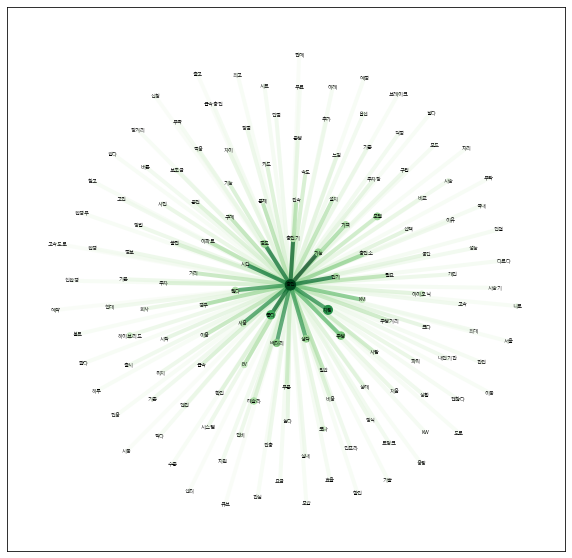

In [15]:
plt.figure(figsize=(10,10))

nx.draw_networkx_nodes(G, pos=pos, node_size=sizes, node_color=sizes,
                       alpha=1, cmap=plt.cm.Greens)
nx.draw_networkx_edges(G, pos=pos, node_size=sizes, edge_color=m.to_rgba(selected_df['support']),
                       width = 4, alpha=0.7, edge_cmap=plt.cm.Greens)
nx.draw_networkx_labels(G, pos=pos, font_family="Malgun Gothic", font_size=5)

ax = plt.gca()
plt.show()

## 3-3. 특정 단어 중심으로: 아이오닉 출시 전후 비교

### 출시 이전

In [16]:
standard = 'support' # 엣지 색 기준 설정

In [17]:
# 아이오닉이 포함된 데이터만 저장
data_아이오닉 = data[data.comment.str.contains('아이오닉')]

In [18]:
# 출시 이전 날짜 세팅
data_selected = data_아이오닉[(data_아이오닉.date >= '2021-04-12') & (data_아이오닉.date <= '2021-04-18')]
len(data_아이오닉[(data_아이오닉.date >= '2021-04-12') & (data_아이오닉.date <= '2021-04-18')])

84

In [19]:
data_list = data_selected['noun_va'].tolist()

# 트랜잭션 생성
transactions = []
for comment in data_list:
    transactions.append(set(word.strip() for word in comment.split(' ') if word.strip() != ''))

# 연관분석 및 데이터프레임화
results = list(apriori(transactions, min_support=0.01, min_confidence=0.1, min_lift=1.0, max_length = 2))
columns = ['source', 'target', 'support', 'confidence', 'lift']

df = []
for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        for r in result[2]:
            if (len(items[0]) > 0) and (len(items[1]) > 0):
                row = [items[0], items[1], round(result.support, 3), round(r[2], 3), round(r[3], 3)]
        df.append(row)
network_df = pd.DataFrame(df, columns=columns)

# 각 단어의 빈도수 계산
noun_list = []
for text in data_selected['noun_va']:
    noun_list += [w for w in text.split(' ')]

counter = Counter(noun_list)
node_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
node_df.columns = ['node', 'nodesize']

In [20]:
G=nx.Graph()

selected_df = network_df.nlargest(50, standard)
selected_df = selected_df.iloc[::-1].reset_index()
norm_standard = [float(i)/max(selected_df[standard]) for i in selected_df[standard]]

for index, row in selected_df.iterrows():
    G.add_node(row['source'], nodesize=node_df[node_df['node'] == row['source']]['nodesize'].values[0])   
    G.add_node(row['target'], nodesize=node_df[node_df['node'] == row['target']]['nodesize'].values[0])
    G.add_edge(row['source'], row['target'], weight=norm_standard[index])

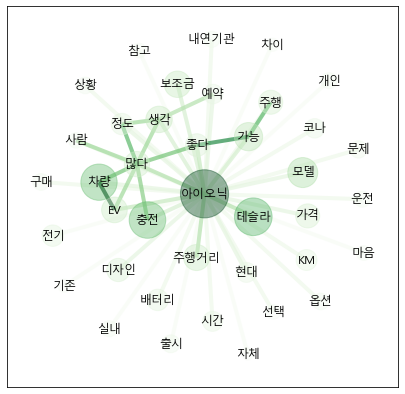

In [21]:
pos = nx.spring_layout(G, k=0.8, iterations=500, seed=1)
sizes = [G.nodes[node]['nodesize']/0.05 for node in G]

import matplotlib

norm = matplotlib.colors.Normalize(vmin=min(selected_df[standard]), vmax=max(selected_df[standard]))
cmap = matplotlib.cm.Greens
m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(7,7))

nx.draw_networkx_nodes(G, pos=pos, node_size=sizes, node_color=sizes,
                       alpha=0.4, cmap=plt.cm.Greens)
nx.draw_networkx_edges(G, pos=pos, node_size=sizes, edge_color=m.to_rgba(selected_df[standard]),
                       width = 4, alpha=0.7, edge_cmap=plt.cm.Greens)
nx.draw_networkx_labels(G, pos=pos, font_family="Malgun Gothic", font_size=12)

ax = plt.gca()
plt.show()

### 출시 이후

In [22]:
data_selected = data_아이오닉[(data_아이오닉.date >= '2021-04-19') & (data_아이오닉.date <= '2021-04-25')]

In [23]:
data_list = data_selected['noun_va'].tolist()

# 트랜잭션 생성
transactions = []
for comment in data_list:
    transactions.append(set(word.strip() for word in comment.split(' ') if word.strip() != ''))

# 연관분석 및 데이터프레임화
results = list(apriori(transactions, min_support=0.01, min_confidence=0.1, min_lift=1.0, max_length = 2))
columns = ['source', 'target', 'support', 'confidence', 'lift']

df = []
for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        for r in result[2]:
            if (len(items[0]) > 0) and (len(items[1]) > 0):
                row = [items[0], items[1], round(result.support, 3), round(r[2], 3), round(r[3], 3)]
        df.append(row)
network_df = pd.DataFrame(df, columns=columns)

# 각 단어의 빈도수 계산
noun_list = []
for text in data_selected['noun_va']:
    noun_list += [w for w in text.split(' ')]

counter = Counter(noun_list)
node_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
node_df.columns = ['node', 'nodesize']

In [24]:
G=nx.Graph()

selected_df = network_df.nlargest(50, standard)
selected_df = selected_df.iloc[::-1].reset_index()
norm_standard = [float(i)/max(selected_df[standard]) for i in selected_df[standard]]

for index, row in selected_df.iterrows():
    G.add_node(row['source'], nodesize=node_df[node_df['node'] == row['source']]['nodesize'].values[0])   
    G.add_node(row['target'], nodesize=node_df[node_df['node'] == row['target']]['nodesize'].values[0])
    G.add_edge(row['source'], row['target'], weight=norm_standard[index])

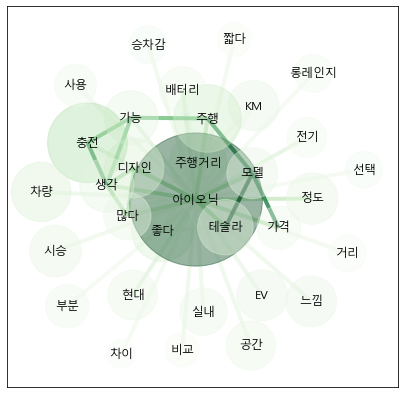

In [25]:
pos = nx.spring_layout(G, k=0.8, iterations=500, seed=1)
sizes = [G.nodes[node]['nodesize']/0.05 for node in G]

import matplotlib

norm = matplotlib.colors.Normalize(vmin=min(selected_df[standard]), vmax=max(selected_df[standard]))
cmap = matplotlib.cm.Greens
m = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(7,7))

nx.draw_networkx_nodes(G, pos=pos, node_size=sizes, node_color=sizes,
                       alpha=0.4, cmap=plt.cm.Greens)
nx.draw_networkx_edges(G, pos=pos, node_size=sizes, edge_color=m.to_rgba(selected_df[standard]),
                       width = 4, alpha=0.7, edge_cmap=plt.cm.Greens)
nx.draw_networkx_labels(G, pos=pos, font_family="Malgun Gothic", font_size=12)

ax = plt.gca()
plt.show()

## 3-4. 연도별
### 같은 파라미터로 그래프 생성 -> 노드 크기(해당 단어의 빈도수)를 통해 전기차에 대한 관심 증가와 키워드 빈도 증가를 파악할 수 있음, iteration 등 파라미터에 따라 달라질 수 있는 그래프 레이아웃을 최대한 배제하고자 함

### 2016년

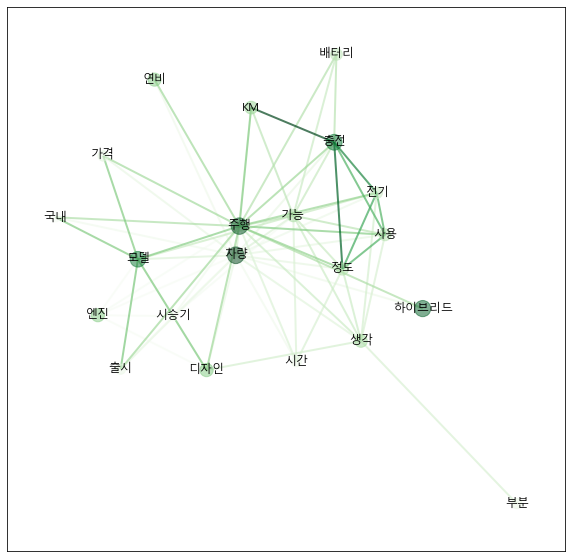

In [26]:
net2016 = get_network(data, '2016-01-01', '2016-12-31', top_n=70, n_iter=100, size_div=10, font_size=12, width=2, most_option=0, va=False)

# 2016년 특징
# 1. 전체적으로 작은 노드 크기(빈도수): 전기차에 대한 관심 저조
# 2. 하이브리드: 내연기관차에서 전기차로 넘어가는 과도기, 이후에는 등장하지 않음 
# 3. 아직 충전이 특별히 돋보이지 않음
# 4. 모델/국내/출시

In [27]:
net2016.nlargest(10, 'support')

,source,target,support,confidence,lift
117315,주행,차량,0.22293,0.64073,1.85694
10825,주행,가능,0.21601,0.62604,2.05446
10863,가능,차량,0.20622,0.59272,1.94509
4611,주행,KM,0.19585,0.56761,2.29157
81617,생각,정도,0.19297,0.61243,1.97617
94511,주행,시승기,0.19240,0.55760,1.92443
60351,주행,모델,0.19182,0.55593,1.88126
94545,시승기,차량,0.18433,0.52980,1.82850
60388,차량,모델,0.18318,0.52649,1.78165
10354,가능,사용,0.18260,0.65496,2.14935


### 2017년

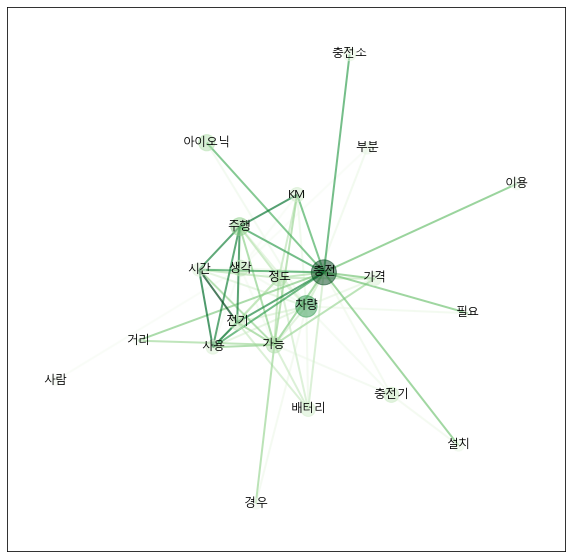

In [28]:
net2017 = get_network(data, '2017-01-01', '2017-12-31', top_n=70, n_iter=50, size_div=10, font_size=12, width=2, most_option=0, va=False)

# 2017년 특징
# 1. 충전에 대한 관심이 시작하는 단계 ++ "충전기", "충전소" 등장
# 2. 2016년 부터 아이오닉 일렉트릭이 출시되어 아이오닉 키워드 등장
# 3. 크게 주행관련(주행/거리/km), 충전관련(충전/시간/충전소/충전기/설치/배터리)으로 나뉨

In [29]:
net2017.nlargest(10, 'support') # 상위 5개가 모두 충전

,source,target,support,confidence,lift
1613,가능,충전,0.10986,0.40420,2.01864
13351,충전,정도,0.10314,0.37948,1.90637
14056,충전기,충전,0.10247,0.58880,2.16634
13186,충전,전기,0.10079,0.37083,2.43389
13808,차량,충전,0.09911,0.36465,1.83495
9503,생각,정도,0.09810,0.49283,2.51181
1588,가능,차량,0.09777,0.49197,2.45696
13329,차량,정도,0.09693,0.48774,2.45024
9539,생각,차량,0.09239,0.46492,2.36958
1549,가능,정도,0.09205,0.46245,2.30952


### 2018년

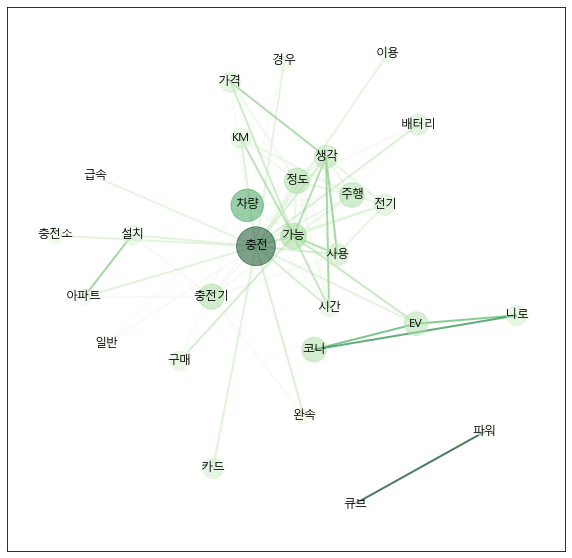

In [30]:
net2018 = get_network(data, '2018-01-01', '2018-12-31', top_n=70, n_iter=50, size_div=10, font_size=12, width=2, most_option=0, va=False)

# 2018년 특징
# 1. 충전을 중심으로 키워드가 분포 -> 아파트/급속/완속/카드 등 충전 관련 키워드 구체화 됨
# 2. 코나, EV, 니로와 같은 구체적인 전기차 모델명 등장
# 3. 파워/큐브 = 전기차 충전 관련 기업

In [31]:
net2018.nlargest(10, 'support')

,source,target,support,confidence,lift
1811,충전기,충전,0.07563,0.54530,2.41762
357,가능,충전,0.06420,0.28464,1.92564
1338,설치,충전기,0.05727,0.41292,4.90274
1700,충전,정도,0.05545,0.24582,1.77292
1780,차량,충전,0.05091,0.22570,1.61269
345,가능,차량,0.05078,0.36287,2.45494
1665,충전,전기,0.04997,0.22156,2.45912
1407,충전,시간,0.04831,0.21420,2.95243
1193,사용,충전,0.04734,0.20988,2.11711
1273,생각,정도,0.04685,0.33791,2.84939


### 2019년

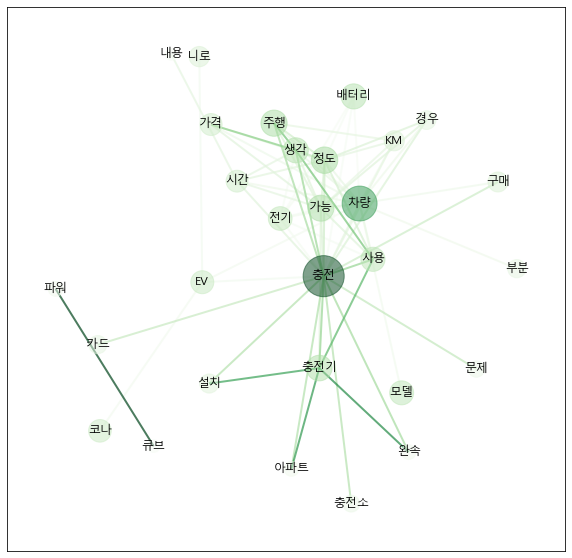

In [32]:
net2019 = get_network(data, '2019-01-01', '2019-12-31', top_n=70, n_iter=50, size_div=10, font_size=12, width=2, most_option=0, va=False)

# 2019년 특징
# 1. 전반적으로 2018년과 유사하면서 키워드 빈도와 지지도가 증가한 경향
# 2. 충전-문제: 충전이 전기차와 관련하여 대표적인 '문제점'으로 부각되었음을 알 수 있음

In [33]:
net2019.nlargest(10, 'support')

,source,target,support,confidence,lift
1501,충전기,충전,0.07035,0.56992,2.36480
277,가능,충전,0.05986,0.24839,1.89907
1156,충전,시간,0.05722,0.23741,2.35490
1396,충전,정도,0.05536,0.22970,1.66140
1361,충전,전기,0.05137,0.21315,2.03452
973,사용,충전,0.04859,0.20160,1.98144
1468,차량,충전,0.04848,0.20117,1.55025
266,가능,차량,0.04515,0.34791,2.65988
1058,생각,충전,0.04422,0.18348,1.57361
1107,설치,충전기,0.04412,0.35738,4.99458


### 2020년

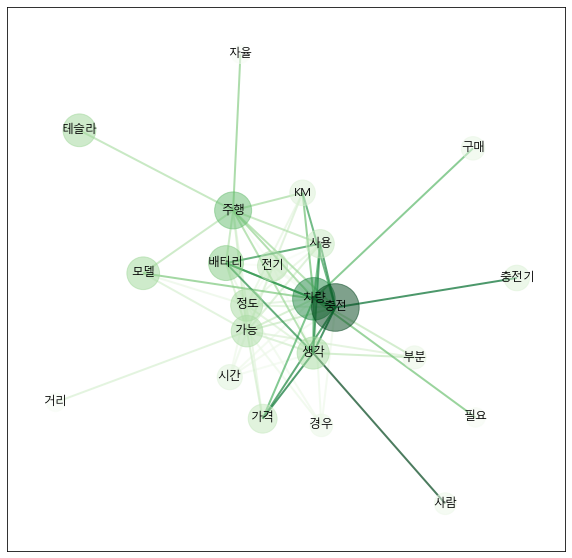

In [34]:
net2020 = get_network(data, '2020-01-01', '2020-12-31', top_n=70, n_iter=50, size_div=10, font_size=12, width=2, most_option=0, va=False)

# 2020년 특징
# 1. 충전 키워드 빈도가 증가하며, 다양한 키워드보다는 몇 가지 키워드가 집중적으로 나타남
# 2. 테슬라, 자율/주행 등장 (테슬라의 자율주행 관련 발표 영향)

In [35]:
net2020.nlargest(10, 'support')

,source,target,support,confidence,lift
319,가능,충전,0.05448,0.26515,2.26034
1776,충전,시간,0.05120,0.24920,3.17238
2112,충전,정도,0.05111,0.24875,1.97477
2060,충전,전기,0.05036,0.24510,2.16907
306,가능,차량,0.04839,0.39678,3.38246
2004,주행,자율,0.04839,0.33495,6.82279
1260,배터리,충전,0.04825,0.23485,1.67329
1616,생각,정도,0.04746,0.37674,3.02292
298,주행,가능,0.04739,0.32799,2.79605
2260,차량,충전,0.04694,0.22847,1.87334


### 2021년

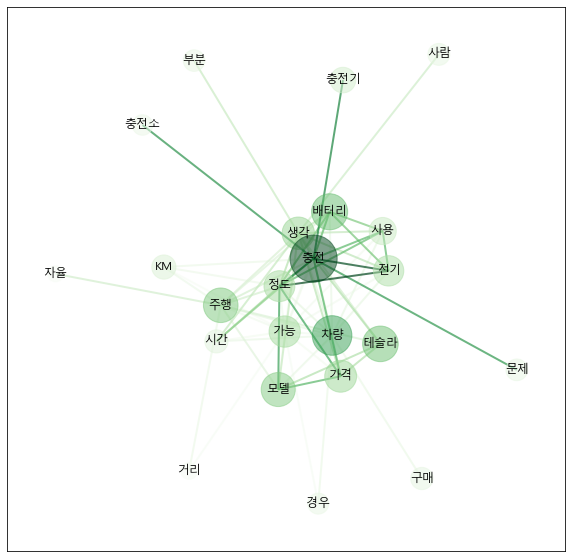

In [36]:
net2021 = get_network(data, '2021-01-01', '2021-7-31', top_n=70, n_iter=50, size_div=10, font_size=12, width=2, most_option=0, va=False)

# 2021년 특징
# 1. 전반적인 키워드는 2020년과 유사하지만, 2021년은 7월까지의 데이터임에도 불구하고 
#    2020년 전체 데이터의 빈도와 유사한 것으로 보아 가장 관심이 증가했음을 알 수 있음
#    -> 전기차와 관련하여 최근의 관심사는 충전과 주행에 집중되어있으며 큰 변함없이 2020년부터 유지되는 경향
#    -> 하지만 관심의 정도는 작년에 비해 눈에 띄게 증가함
# 2. 충전 - 충전기/충전소/배터리/시간
# 3. 주행 - 자율/거리/KM

In [37]:
net2021.nlargest(10, 'support')

,source,target,support,confidence,lift
121,가능,충전,0.03972,0.22400,2.44777
535,충전,전기,0.03927,0.22142,2.30658
317,배터리,충전,0.03542,0.19970,1.62773
454,충전,시간,0.03540,0.19960,3.66045
548,충전,정도,0.03417,0.19266,1.99641
112,주행,가능,0.03378,0.32860,3.59087
414,생각,정도,0.03313,0.34329,3.23702
423,생각,충전,0.03267,0.18423,1.73719
115,가능,차량,0.03120,0.36714,4.01197
521,주행,자율,0.03102,0.30174,9.52254
